In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Problem 1: Geometric Brownian Motion

$$ dS_t = \mu S_tdt + \sigma S_t dW_t,  \\ S_0 = s_0$$

$$ S_t = S_0 \exp [(\mu - \sigma^2 /2)t + \sigma W_t] $$

In [50]:
n = 3650
mu = 0.06
sigma = 0.2
M = 10.0
s0 = 100.0

def exact_simulation(s0, mu, sigma, n):
    dt = 1.0/365.0 # frequency = delta = T/n where T = 1 year and n = 365 days
    dz = np.random.randn(n)*np.sqrt(dt)
    S = s0 * np.exp(np.cumsum((mu-(sigma**2)/2)*dt + sigma*dz))
    return S

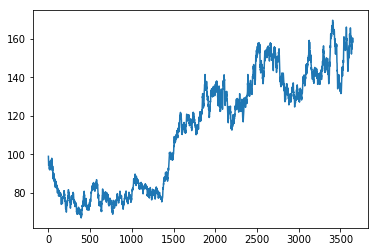

In [66]:
plt.plot(exact_simulation(s0, mu, sigma, n))
plt.show()

In [52]:
# daily continuously compounded returns: r_t = log(1 + R_t) 
prices = exact_simulation(s0, mu, sigma, n)
prices_lagged = np.diff(prices)
R_t = prices_lagged/prices[:-1]
r_t = np.log(1 + R_t)

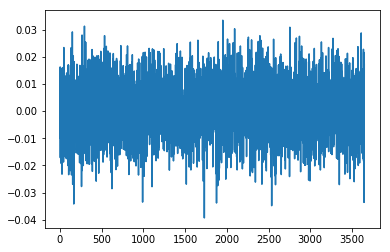

In [53]:
plt.plot(r_t)

In [126]:
def compute_annual_mean_std(normal_ret, log_ret, n, dt):
    annual_mean = np.sum(log_ret)*1/(n*dt)
    annual_std = np.sum((normal_ret - annual_mean)**2)*(1/(n-1)*dt)
    return annual_mean, annual_std

In [118]:
dt = 1.0/365.0
annualised_mean, annualised_std = compute_annual_mean_std(R_t, r_t, n, dt)
print(f"Annualised mean: {annualised_mean} \n")
print(f"Annualised std: {annualised_std}")

Annualised mean: 0.6944671878010993 

Annualised std: 0.005823287281046036


### Problem 2

In [48]:
index = pd.period_range(start="01-01-1950", end="31-12-2018", freq="D")

In [58]:
simulated_ts = pd.DataFrame(exact_simulation(s0, mu, sigma, len(index)), index, columns=["ret"])

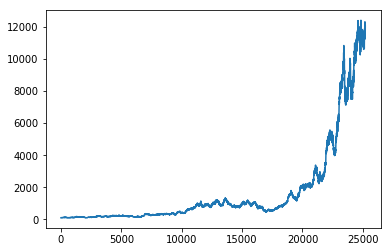

In [73]:
plt.plot(list(simulated_ts.ret))

### Problem 3:

In [102]:
def compute_log_ret(series):
    normal_ret = np.diff(series)/series[:-1] 
    return normal_ret, np.log(1 + normal_ret)

Annualised mean for weekly returns: 0.00999646500460526


In [119]:
daily_ret, log_daily_ret = compute_log_ret(simulated_ts.ret)
weekly_ret, log_weekly_ret = compute_log_ret(simulated_ts.ret.resample("W").mean())
monthly_ret, log_monthly_ret = compute_log_ret(simulated_ts.ret.resample("M").mean())

freq_dict = {"daily returns": (daily_ret, log_daily_ret, 1./365.), 
             "weekly returns": (weekly_ret, log_weekly_ret, 1./52.), 
             "montly returns": (monthly_ret, log_monthly_ret, 1./12.)}

In [123]:
for tit,freq in freq_dict.items():
    n = len(freq)
    print(f"Summary for {tit}:\n")
    print(freq[1].describe())
    annual_mean, annual_std = compute_annual_mean_std(freq[0], freq[1], len(freq[0]), freq[2])
    print(f"Annualised mean, std: {annual_mean, annual_std}\n")

Summary for daily returns:

count    25201.000000
mean         0.000190
std          0.010447
min         -0.046856
25%         -0.006841
50%          0.000204
75%          0.007125
max          0.046832
Name: ret, dtype: float64
Annualised mean, std: (0.06935645282818638, 1.3385916345954246e-05)

Summary for weekly returns:

count    3601.000000
mean        0.001330
std         0.022692
min        -0.077150
25%        -0.013966
50%         0.001540
75%         0.017186
max         0.075374
Name: ret, dtype: float64
Annualised mean, std: (0.06914997152358947, 9.77296462880527e-05)

Summary for montly returns:

count    827.000000
mean       0.005795
std        0.047223
min       -0.150334
25%       -0.025435
50%        0.007352
75%        0.036441
max        0.150714
Name: ret, dtype: float64
Annualised mean, std: (0.06954141270475954, 0.000514614206526755)



In [145]:
rolling_log_daily_ret = log_daily_ret.rolling(365).mean().fillna(0)
rolling_log_weekly_ret = log_weekly_ret.rolling(52).mean().fillna(0)
rolling_log_monthly_ret = log_monthly_ret.rolling(12).mean().fillna(0)

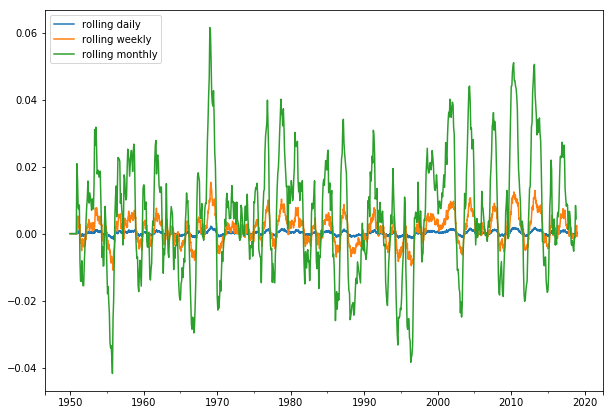

In [149]:
plt.figure(figsize=(10,7))
rolling_log_daily_ret.plot(label="rolling daily")
rolling_log_weekly_ret.plot(label="rolling weekly")
rolling_log_monthly_ret.plot(label="rolling monthly")
plt.legend(loc="best")
plt.show()

### Problem 4: WRDS dataset

In [4]:
import wrds
db = wrds.Connection(wrds_username='hienle')
db.create_pgpass_file()

Enter your WRDS username [hienle]:hienle
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [44]:
# (b) Download daily stock returns 2 for the period starting on January 1 st , 2000 and ending
# on December 12 st , 2018 of the following companies: Apple, Goldman Sachs, Microsoft,
# Procter and Gamble, and General Electric.

companies = {"aapl": 7, "gs": 35048, "msft": 8048, "pg": 21446, "ge": 20792}
ind = pd.date_range(start='2001-01-01', end='2018-12-31')
df = pd.DataFrame(index=ind)

In [45]:
for key,value in companies.items():
    rets = db.raw_sql(f"select date, ret from crsp.dsf where permco in ({value}) \
                      and date>='2001-01-01' and date<='2018-12-31'").set_index("date").rename(columns={"ret":key})
    
    df = pd.merge(df, rets, left_index=True, right_index=True)

In [47]:
df.to_csv("as1_ex4_data.csv")